In [1]:
using PyPlot

# Sequential Inference of Cascading Latent Force Model

$$
\frac{\partial}{\partial t}f_1(\cdot,t) = \mathcal{A}_1f_1(\cdot,t) + \mathcal{B}_1u(\cdot,t)
$$
$$
\frac{\partial}{\partial t}f_2(\cdot,t) = \mathcal{A}_2f_2(\cdot,t) + \mathcal{B}_2f_1(\cdot,t)
$$
$$
\vdots
$$
$$
\frac{\partial}{\partial t}f_n(\cdot,t) = \mathcal{A}_nf_n(\cdot,t) + \mathcal{B}_nf_{n-1}(\cdot,t)
$$
$$
y(\cdot,t) = \mathcal{H}f_n(\cdot,t) + \nu(\cdot, t),\qquad \nu \sim \mathcal{N}(\mathbf{0}, \mathbf{R})
$$

### Example: brine tank cascade

(taken from [here](http://www.math.utah.edu/~gustafso/s2008/systemsBrineTankHeating.pdf))

```
    ↓ ___
   | (1) |__
   |_______↴|____
        |        |___
        |  (2)    __↴|_________
        |________| |           |
                   |   (3)     |
                   |_____     _|
                         | ↓ |
```
Brine tanks, (1),(2),(3) with fixed volume. Assumption that the fluid enters each tank at a rate of $r^{(i)}_{in}$ and out of each tank at a rate of $r^{(i)}_{out}$, where $i$ is the tank number. In the basic case, it is assumed that the volume is fixed, such that $r^{(i)}_{in} = r^{(i-1)}_{out}$ for $i = 2,3$. Modelling the amount of salt in each tank at a given time, assume uniform concentration in a given tank, and that there is some initial concentration of salt in each tank and that there is some input of unknown (variable) concentration at a given time.

$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_1(t) = a_1f_1(t) + u(t)
$$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_2(t) = a_2f_2(t) - a_1f_1(t)
$$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_3(t) = a_3f_3(t) - a_2f_2(t)
$$

The concentration in each tank cannot be directly observed, so the observation is the output from tank (3) with additive Gaussian noise:
$$
    y(t) = -a_3f_3(t) + \nu(t)
$$

Modelling the input function $u(t)$ as a Gaussian process gives a system of stochastic differential equations, where the concentration of salt in each tank, $f_i$ is also a Gaussian process.

Modelling the system as a joint Gaussian distribution gives the following single latent force model:

$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}(t) = \mathbf{A}\mathbf{f}(t) + \mathbf{L}u(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}(t) = \begin{bmatrix}f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
        a_1 & 0 & 0 \\
        -a_1 & a_2 & 0 \\ 
        0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & 1\end{bmatrix}
$$

## Modelling

In [2]:
a₁, a₂, a₃ = -1./2., -1./4., -1./6.
𝐟₀ = [2, 5, 2.5] # initial concentration of salt in each tank

𝐀 = [ a₁  0.  0. ;
     -a₁  a₂  0. ;
      0. -a₂  a₃ ]

𝐋 = [1 ; 0 ; 0]
; #suppress output

In [3]:
## Discretise system
nₜ = 1000
𝐭 = linspace(0., 5., nₜ)

Δₜ = 𝐭[2] - 𝐭[1] # discretise
𝐅  = expm(Δₜ * 𝐀);

### Model solution with no saline input
This assumes tank 1 is being filled with 0-concentration water

In [4]:
# Analytic solution for no input
𝑓(t) = [  [𝐟₀[1]*exp.(-t/2)] ;
        [-2𝐟₀[1]*exp.(-t/2) + (𝐟₀[2] + 2𝐟₀[1])*exp.(-t/4)] ; 
         [1.5*𝐟₀[1]*exp.(-t/2) - 3*(𝐟₀[2] + 2𝐟₀[1])*exp.(-t/4) + (𝐟₀[3]-1.5*𝐟₀[1] + 3*(𝐟₀[2] + 2𝐟₀[1]))*exp.(-t/6)]]
; # suppress output

In [5]:
𝒇ₜ = Array{typeof(𝐟₀)}(nₜ)
#𝐟ₜ = 𝐟₀
𝒇ₜ[1] = 𝐟₀

for k ∈ 2:nₜ
    𝒇ₜ[k] = 𝐅 * 𝒇ₜ[k-1]
end

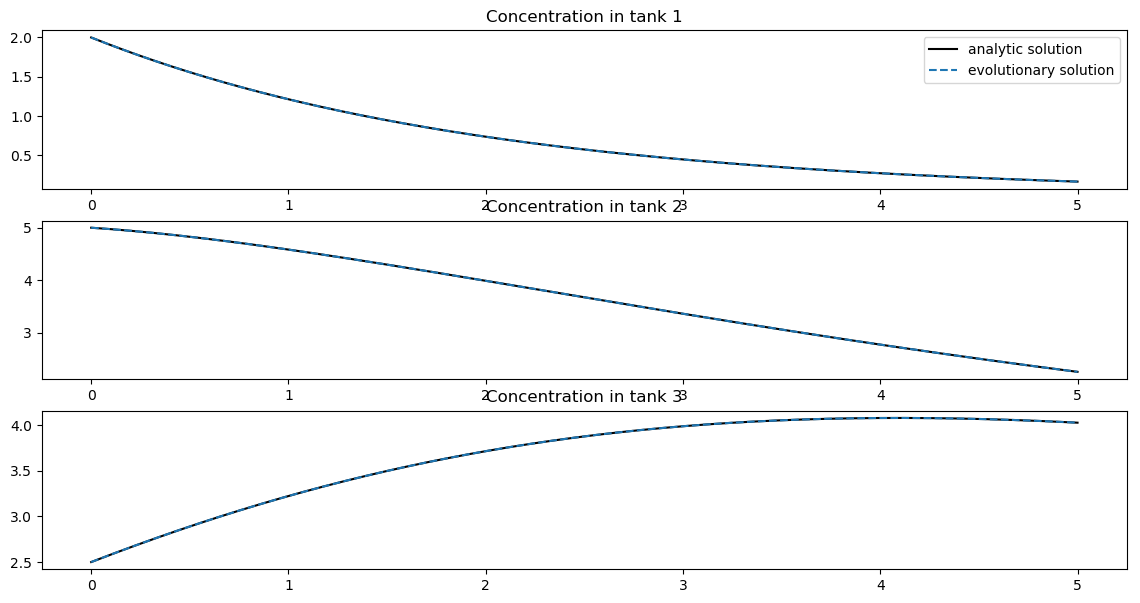

In [6]:
#_,axs = subplots(4,1,:true,:false)

figure(figsize=(14,7))

for i ∈ 1:3
    subplot(310+i)
    plot(𝐭, 𝑓(𝐭)[i],"k-")
    plot(𝐭, [f[i] for f ∈ 𝒇ₜ],"--")
    title(@sprintf("Concentration in tank %d", i))
    i == 1 ? legend(labels=["analytic solution", "evolutionary solution"]) : nothing
end
;

### Model the input

Now add an input function to the model:

In [7]:
## Input
# Injection start and stop times
tₛₜₐᵣₜ, tₛₜₒₚ = [0.1, 1.8, 3.], [0.4, 2., 4.]
# Injection gradient (controls slope of injection from 0 to 1 and vice versa)
σᵤ = 100.

𝑢(t)  = sum([(1 + exp.(σᵤ*(a-t))).^(-1).*(1 + exp.(σᵤ*(t-b))).^(-1) for (a,b) ∈ zip(tₛₜₐᵣₜ, tₛₜₒₚ)])
∫𝑢(t) = sum([(log.(exp.(σᵤ*(a-b))+exp.(σᵤ*(a-t)))-log.(exp.(σᵤ*(a-t))+1))/(σᵤ*(exp(σᵤ*(a-b))-1)) for (a,b) ∈ zip(tₛₜₐᵣₜ, tₛₜₒₚ)]) 

∫𝑢 (generic function with 1 method)

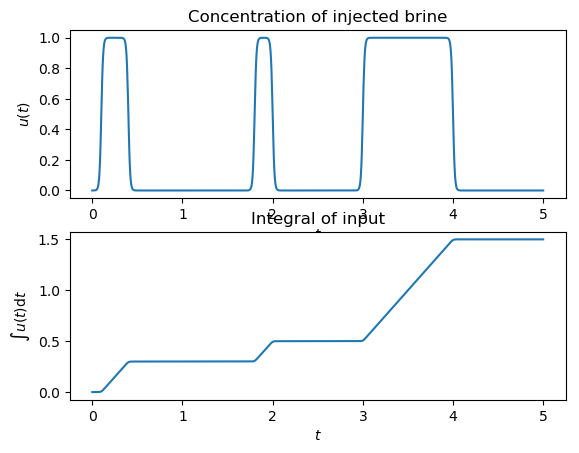

PyObject Text(0.5,1,'Integral of input')

In [8]:
subplot(211)
plot(𝐭, 𝑢(𝐭), "-")
xlabel(L"$t$"), ylabel(L"$u(t)$")
title("Concentration of injected brine");

subplot(212)
plot(𝐭, ∫𝑢(𝐭),"-")
xlabel(L"$t$"), ylabel(L"$\int u(t)\mathrm{d}t$")
title("Integral of input")

In [9]:
𝒇ₜ = Array{typeof(𝐟₀)}(nₜ)

𝒇ₜ[1] = 𝐟₀
for k ∈ 2:nₜ
    𝒇ₜ[k] = 𝐅 * 𝒇ₜ[k-1] + 𝐋*(∫𝑢(𝐭[k]) - ∫𝑢(𝐭[k-1]))
end

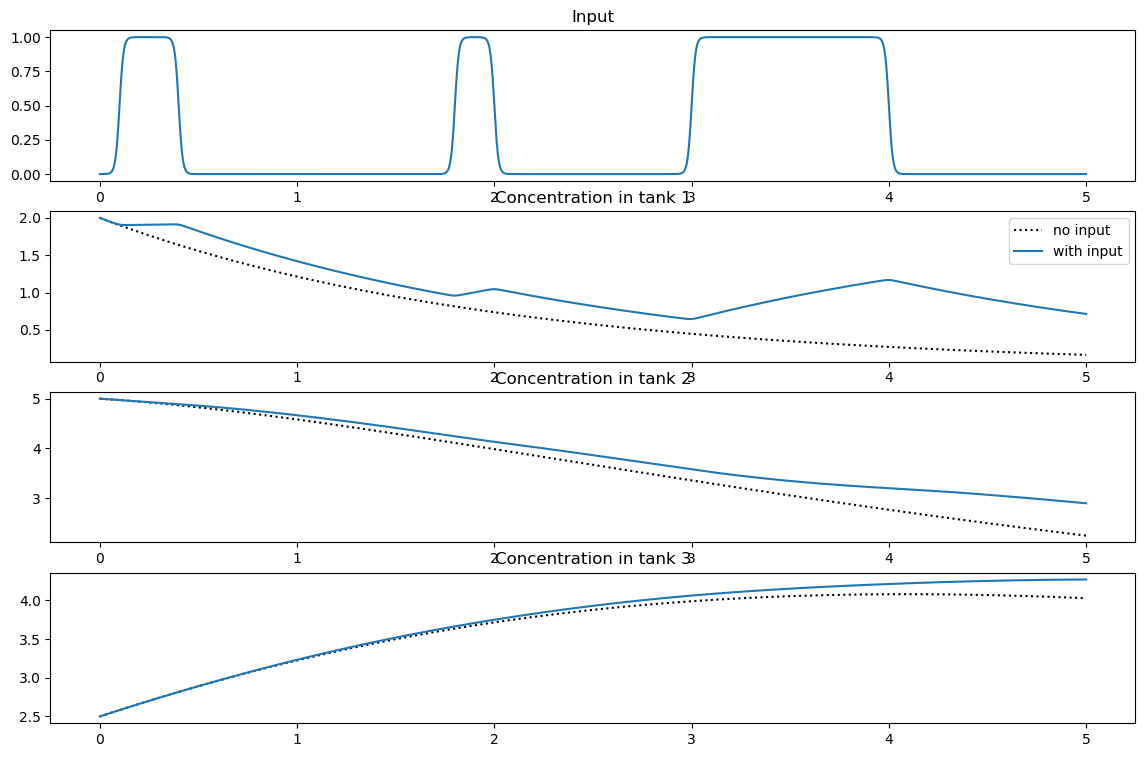

In [10]:
figure(figsize=(14,9))

subplot(411)
plot(𝐭, 𝑢(𝐭), "-")
title("Input")

for i ∈ 1:3
    subplot(411+i)
    plot(𝐭, 𝑓(𝐭)[i],"k:")
    plot(𝐭, [f[i] for f ∈ 𝒇ₜ],"-")
    title(@sprintf("Concentration in tank %d", i))
    i == 1 ? legend(labels=["no input","with input"]) : nothing
end
;

## An observation model

$$ y(t) = -a_3f_3(t) + \nu(t),\qquad \nu \sim \mathcal{N}(0, \sigma^2_\nu)$$

Sample for some discrete number of points in time

In [11]:
#nₛ = 100

𝐭ₛ = 𝐭[1:10:end]

nₛ = length(𝐭ₛ)
𝐲ₜ = Array{typeof(𝐟₀)}(nₛ)

𝐇  = [0 0 -a₃]
𝑹  = 0.01 # observation noise covariance

𝑓ₜ = 𝐟₀

𝐲ₜ[1] = 𝐇*𝐟₀

for k ∈ 2:nₛ
    𝑓ₜ = expm((𝐭ₛ[k]-𝐭ₛ[k-1])*𝐀) * 𝑓ₜ + 𝐋*(∫𝑢(𝐭ₛ[k]) - ∫𝑢(𝐭ₛ[k-1]))
    𝐲ₜ[k] = 𝐇*𝑓ₜ + √𝑹 * randn()
end

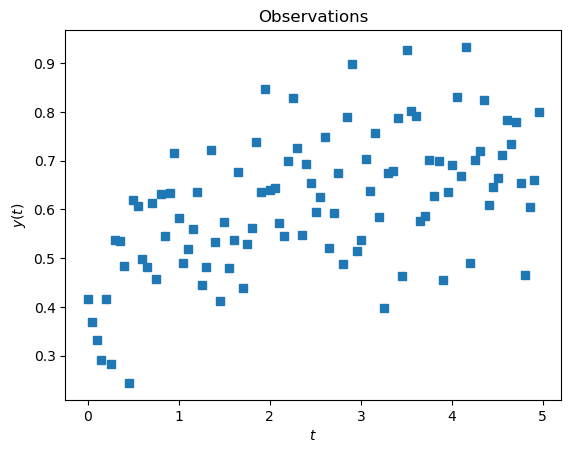

PyObject Text(0.5,1,'Observations')

In [12]:
plot(𝐭ₛ, 𝐲ₜ, "s")
xlabel(L"t"), ylabel(L"y(t)")
title("Observations")

## Learning the input u(t)

The idea is to model the latent force, $u(t)$, which is a GP, as a linear time-invariance SDE (as in [Hartikainen and Sarkka, (2011)](https://users.aalto.fi/~ssarkka/pub/silfm_uai2011.pdf)):


First, the following example shows GP regression for some discrete-time samples. The Matern-$\frac{3}{2}$ covariance function is used, with $\mathscr{l} = 0.5$ and $\sigma_\kappa^2 = 1.$

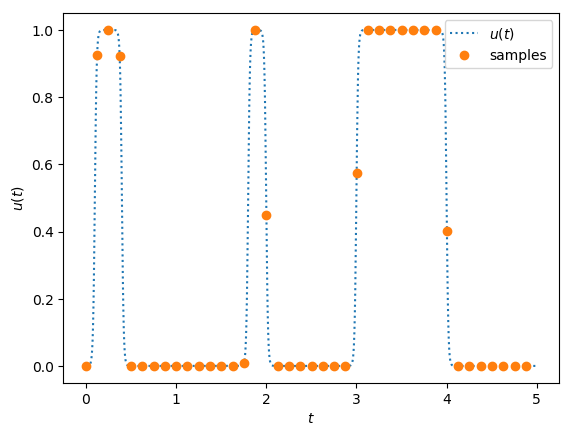

In [13]:
𝐭ᵤ = 𝐭[1:25:end]

plot(𝐭, 𝑢(𝐭), ":", 𝐭ᵤ, 𝑢(𝐭ᵤ), "o")
xlabel(L"$t$"), ylabel(L"$u(t)$")
legend(labels=[L"u(t)", "samples"])
; #suppress text output

In [14]:
include("GP.jl")
params = Dict("nu" => 1.5, "lengthscale"=>0.5, "variance"=>1.)

gp_predict = trained_gp(𝐭ᵤ, 𝑢(𝐭ᵤ), σ²=eps(), 𝑘=kern_matern, θ=params)

μ, Σ = gp_predict(𝐭);

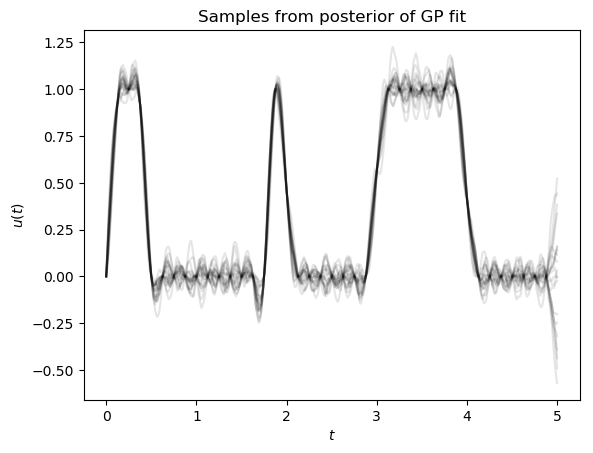

In [15]:
s = sample_posterior(μ, Σ, n=20)
for i ∈ 1:20
    plot(𝐭, s[i], "k-", alpha=0.1)
end
title("Samples from posterior of GP fit")
xlabel(L"$t$"), ylabel(L"$u(t)$");

_Obviously this is not great, since the function cannot be Gaussian output, since strictly >0_

## Construct SDE representation of u(t)

Taking the covariance function used in the GP regression,

$$
\kappa_u(t,t') = \sigma^2_\kappa\left(1 + \frac{\sqrt{3}|t-t'|}{\mathscr{l}}\right)\exp\left(-\frac{\sqrt{3}|t-t'|}{\mathscr{l}}\right)
$$

The LTI SDE representation of $u(t) \sim \mathcal{GP}(0, \kappa_u(t,t'))$ is:

$$
\frac{\mathrm{d}}{\mathrm{d}t}\mathbf{u}(t) = \underbrace{\begin{bmatrix}0 & 1 \\ -\lambda^2 & -2\lambda\end{bmatrix}}_{\mathscr{F}_u}\mathbf{u}(t) + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{\mathcal{L}_u}\mathbf{w}(t)
$$

Where $u(t) = \begin{bmatrix}1&0\end{bmatrix}\mathbf{u}(t)$, $\lambda = \sqrt{3}/\mathscr{l}$, and $\mathbf{P}_\infty = \mathrm{diag}[\sigma_\kappa^2 , \lambda^2\sigma_\kappa^2]$, $q = \frac{4\lambda^3}{\sigma_\kappa^2}$

In [16]:
l, σₖ² = 0.5, 1.
λ = √3 / l

ℱ = [0 1 ; -λ^2 -2λ]
P∞ = diagm([σₖ², λ^2*σₖ²])
κᵤ(t) = kern_matern(t, 0., ν=3/2, ls=l, v = σₖ²) # explicit covariance definition
𝐶ᵤ(t) = t ≥ 0. ? [1 0]*P∞*expm(t*ℱ)'*[1;0] : [1 0]*expm(-t*ℱ)*P∞*[1;0]; # SSM-based definition

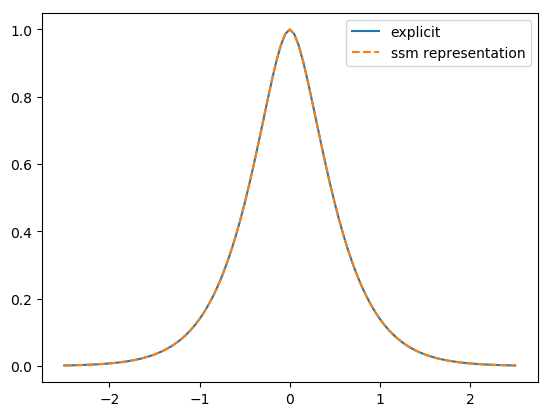

PyObject <matplotlib.legend.Legend object at 0x7f653f815dd8>

In [17]:
τ = -5l:l/10.:5l

plot(τ, map(κᵤ, τ), "-", τ, map(𝐶ᵤ, τ), "--")
legend(labels=["explicit", "ssm representation"])

In [18]:
filter = (F,Q,H,R)->((m,P)->(F*m,F*P*F'+Q),(m,P,y)->(m+(P*H'/(H*P*H'+R))*(y-H*m),P-(P*H'/(H*P*H'+R))*(H*P*H'+R)*(P*H'/(H*P*H'+R))'))
smoother = (F,Q)->((m⁻,m⁺,P⁻,P⁺)->(m⁻+(P⁻*F'/(F*P⁻*F'+Q))*(m⁺-F*m⁻),P⁻+(P⁻*F'/(F*P⁻*F'+Q))*(P⁺-F*P⁻*F'+Q)*(P⁻*F'/(F*P⁻*F'+Q))'))

(::#80) (generic function with 1 method)

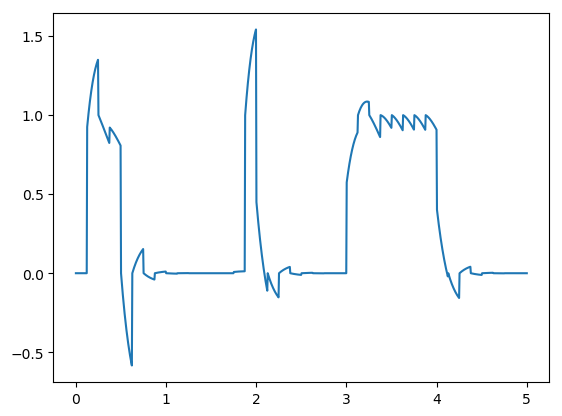

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f653b4f7a20>

In [19]:
m₀, P₀ = [0.;0.], P∞

m, P = Array{typeof(m₀)}(nₜ), Array{typeof(P₀)}(nₜ)

𝒜 = expm(Δₜ*ℱ)
predict, update = filter(𝒜, P∞ - 𝒜*P∞*𝒜', [1. 0.], eps())

mₜ, Pₜ = m₀, P₀
for k ∈ 1:nₜ
    mₜ, Pₜ = predict(mₜ, Pₜ)
    if 𝐭[k] ∈ 𝐭ᵤ
        mₜ, Pₜ = update(mₜ, Pₜ, 𝑢(𝐭[k]))
    end
    m[k] = mₜ
    P[k] = Pₜ
end

plot(𝐭, map(𝜇 -> [1 0]*𝜇, m), "-")

In [20]:
smooth = smoother(𝒜, P∞ - 𝒜*P∞*𝒜')

for k = nₜ-1:-1:1
    m[k], P[k] = smooth(m[k],m[k+1],P[k],P[k+1]) 
end

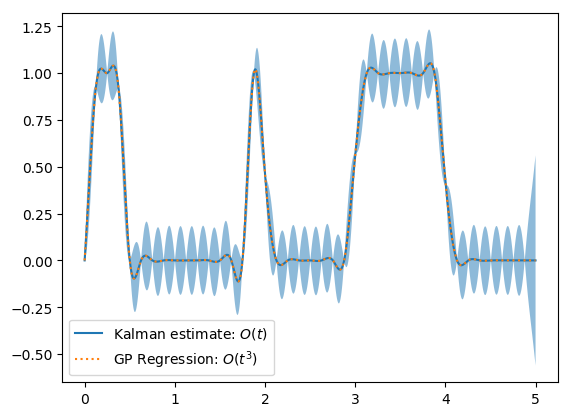

PyObject <matplotlib.legend.Legend object at 0x7f653b4ac0b8>

In [21]:
plot(𝐭, map(𝜇 -> [1 0]*𝜇, m), "-")
fill_between(𝐭,[μ[1] - 1.96*√σ[1] for (μ,σ) ∈ zip(m, P)], [μ[1] + 1.96*√σ[1] for (μ,σ) ∈ zip(m, P)], alpha=0.5)
plot(𝐭, μ, ":")

legend(labels=[L"Kalman estimate: $O(t)$", L"GP Regression: $O(t^3)$"])

# Augment the system with the SDE parameterisation of u(t)


$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}^a(t) = \mathbf{A}^a\mathbf{f}^a(t) + \mathbf{L}^a\mathbf{w}(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}^a(t) = \begin{bmatrix}\mathbf{u}(t)\\f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
      0 & 1 & 0 & 0 & 0\\
     -\lambda^2 & -2\lambda & 0 & 0 & 0\\
      1 & 0 & a_1 & 0 & 0 \\
      0 & 0 & -a_1 & a_2 & 0 \\ 
      0 & 0 &  0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & 0 & 0& -a_3\end{bmatrix}
$$

In [22]:
a₁, a₂, a₃ = -1./2., -1./4., -1./6.

𝐀 = [ a₁  0.  0. ;
     -a₁  a₂  0. ;
      0. -a₂  a₃ ]
𝐟⁻ = inv(expm(Δₜ*𝐀))*[2.; 5.; 2.5;]

𝐟₀ = [0.; 0.; 𝐟⁻] # initial conditions

𝐀 = [   0.   1. 0.  0.  0. ;
       -λ^2 -2λ 0.  0.  0. ;
        1.   0. a₁  0.  0. ;
        0.   0. -a₁  a₂  0.;
        0.   0. 0. -a₂  a₃ ]

𝐅 = expm(Δₜ*𝐀[1:2,1:2])
P∞ = diagm([σₖ², λ^2*σₖ²])
𝑸 = [P∞ - 𝐅*P∞*𝐅' zeros(2,3) ; zeros(3, 5) ] + eps()*eye(5)

𝐅 = expm(Δₜ*𝐀)

𝐇 = [0 0 0 0 -a₃]
𝑹 = 0.01

m₀, P₀ = 𝐟₀, [P∞ zeros(2,3) ; zeros(3, 5)]
; #suppress output

In [23]:
P∞ - 𝐅*P∞*𝐅'

LoadError: [91mDimensionMismatch("A has dimensions (5,5) but B has dimensions (2,2)")[39m

In [24]:
predict, update = filter(𝐅, 𝑸, 𝐇, 𝑹)

𝐟ᵃ, 𝐏ᵃ = Array{typeof(m₀)}(nₜ), Array{typeof(P₀)}(nₜ)

mₜ, Pₜ = m₀, P₀
# 𝐟ᵃ[1] = mₜ
# 𝐏ᵃ[1] = Pₜ
for k ∈ 1:nₜ
    mₜ, Pₜ = predict(mₜ, Pₜ)
    
    if 𝐭[k] ∈ 𝐭ₛ
        j = find(𝐭[k] .== 𝐭ₛ)[1]
        mₜ, Pₜ = update(mₜ, Pₜ, 𝐲ₜ[j])
    end
    𝐟ᵃ[k] = mₜ
    𝐏ᵃ[k] = Pₜ
end

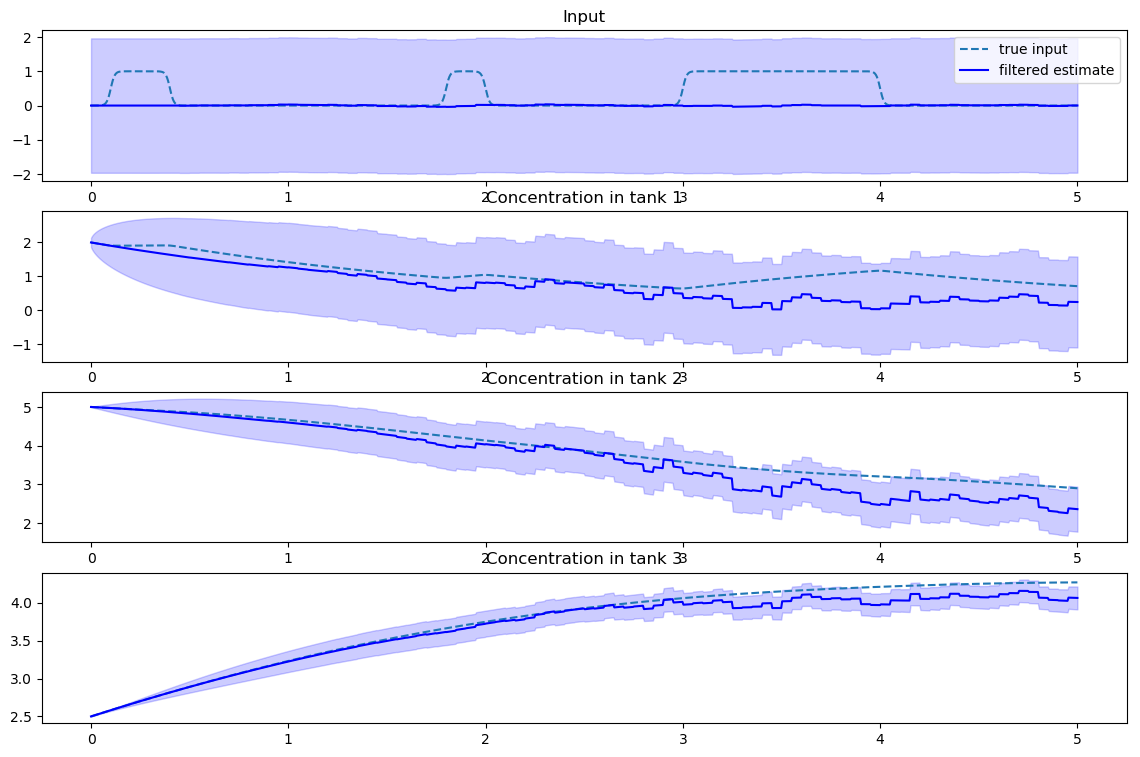

In [25]:
figure(figsize=(14,9))

subplot(411)
plot(𝐭, 𝑢(𝐭), "--")
plot(𝐭, [f[1] for f ∈ 𝐟ᵃ],"b-")

fill_between(𝐭,
             [f[1] - 1.96*√σ[1] for (f,σ) ∈ zip(𝐟ᵃ, 𝐏ᵃ)],
             [f[1] + 1.96*√σ[1] for (f,σ) ∈ zip(𝐟ᵃ, 𝐏ᵃ)],
             color="b", alpha=0.2)

legend(labels=["true input","filtered estimate"])
title("Input")

for i ∈ 1:3
    subplot(411+i)
    plot(𝐭, [f[i] for f ∈ 𝒇ₜ],"--")
    
    plot(𝐭, [f[i+2] for f ∈ 𝐟ᵃ],"b-")
    fill_between(𝐭,
                 [f[i+2] - 1.96*√σ[i+2] for (f,σ) ∈ zip(𝐟ᵃ, 𝐏ᵃ)],
                 [f[i+2] + 1.96*√σ[i+2] for (f,σ) ∈ zip(𝐟ᵃ, 𝐏ᵃ)],
                 color="b", alpha=0.2)
    
    title(@sprintf("Concentration in tank %d", i))
    #i == 1 ? legend(labels=["no input","with input"]) : nothing
end

In [26]:
smooth = smoother(𝐅, 𝑸)
𝐟ˢ, 𝐏ˢ = copy(𝐟ᵃ), copy(𝐏ᵃ)

for k = nₜ-1:-1:1
    𝐟ˢ[k], 𝐏ˢ[k] = smooth(𝐟ˢ[k],𝐟ˢ[k+1],𝐏ˢ[k],𝐏ˢ[k+1]) 
end

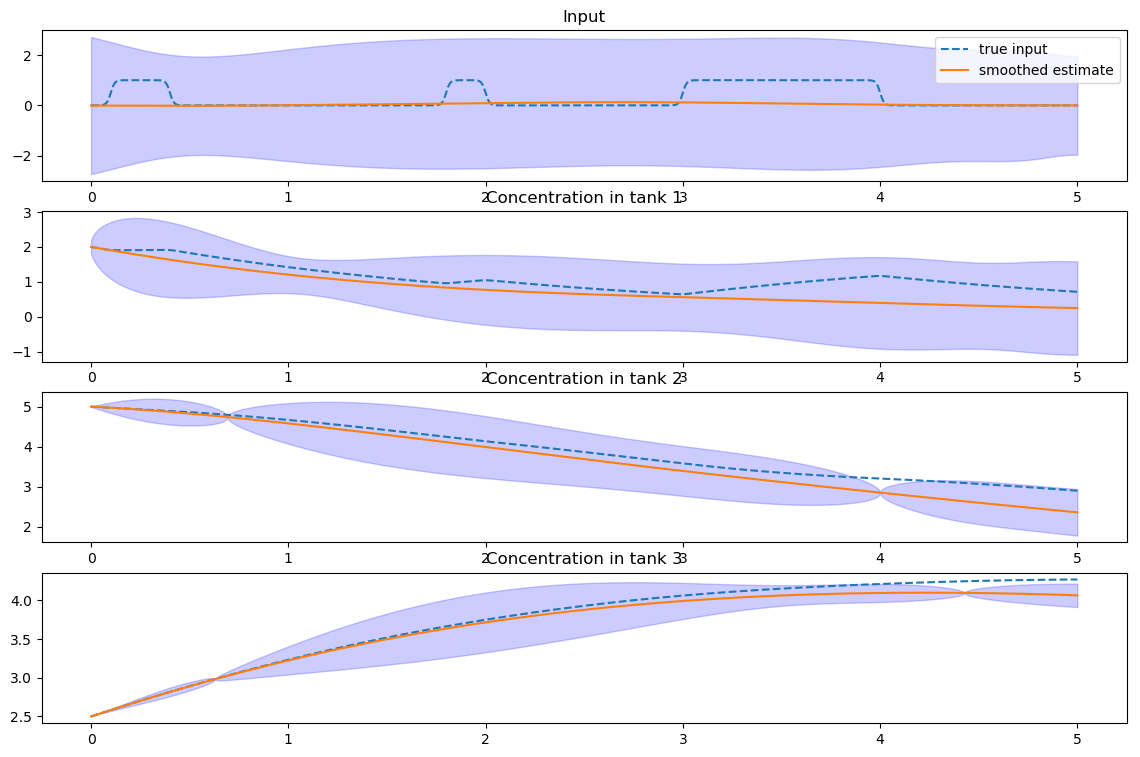

In [27]:
figure(figsize=(14,9))

subplot(411)
plot(𝐭, 𝑢(𝐭), "--")
plot(𝐭, [f[1] for f ∈ 𝐟ˢ],"-")
fill_between(𝐭,
             [f[1] - 1.96*√σ[1] for (f,σ) ∈ zip(𝐟ˢ, 𝐏ˢ)],
             [f[1] + 1.96*√σ[1] for (f,σ) ∈ zip(𝐟ˢ, 𝐏ˢ)],
             color="b", alpha=0.2)
legend(labels=["true input","smoothed estimate"])
title("Input")

for i ∈ 1:3
    subplot(411+i)
    plot(𝐭, [f[i] for f ∈ 𝒇ₜ],"--")
    
    plot(𝐭, [f[i+2] for f ∈ 𝐟ˢ],"-")
    fill_between(𝐭,
                 [f[i+2] - 1.96*√abs(σ[i+2]) for (f,σ) ∈ zip(𝐟ˢ, 𝐏ˢ)],
                 [f[i+2] + 1.96*√abs(σ[i+2]) for (f,σ) ∈ zip(𝐟ˢ, 𝐏ˢ)],
                 color="b", alpha=0.2)
    
    #ylim(-1.1, 5.1)
    title(@sprintf("Concentration in tank %d", i))
    #i == 1 ? legend(labels=["no input","with input"]) : nothing
end